# YOLOv8 Object Detection: Sparse Transfer Learning

This page explains how to fine-tune a pre-sparsified YOLOv8 model with SparseML's CLI.

## Overview

Sparse Transfer is quite similar to the typical YOLOv8 training, where a checkpoint pre-trained on COCO is fine-tuned onto a smaller downstream dataset. However, with Sparse Transfer Learning, the fine-tuning process is started from a pre-sparsified YOLOv8 and maintains sparsity during the training process.

SparseZoo contains pre-sparsified checkpoints of each YOLOv8 model. These models can be used as the starting checkpoint for the sparse transfer learning workflow.

[Check out the full list of pre-sparsified YOLOv8 models](https://sparsezoo.neuralmagic.com/?modelSet=computer_vision&searchModels=&architectures=yolov8)

## Installation for Sparse Transfer

Install via `pip`:

In [ ]:
!pip install "sparseml[ultralytics]==1.7"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.4/952.4 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 47.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.6/612.6 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 73.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-

## SparseML CLI

SparseML's CLI is built on top of YOLOv8's [`train` cli](https://docs.ultralytics.com/usage/cli/) script. This enables you to kick off sparse training workflows with all of the friendly utilities from the Ultralytics repository like dataset loading and preprocessing, checkpoint saving, metric reporting, and logging handled for you. Appending the `--help` argument will provide a full list of options for training in SparseML:

```bash
sparseml.ultralytics.train --help
```

output:
```
usage: sparseml.yolov5.train [-h] [--model MODEL] [--data DATA] [--recipe RECIPE] [--recipe-args RECIPE_ARGS] [--batch BATCH_SIZE] [--epochs EPOCHS] [--imgsz IMGSZ]
                             [--resume] [--patience PAIENCE] [--save] [--cache] [--device [DEVICE]] [--workers WORKERS] [--project [PROJECT]]
                             ...
                            
```

SparseML inherits most arguments from the Ultralytics repository. [Check out the YOLOv8 documentation for usage](https://docs.ultralytics.com/usage/cli/).

## Sparse Transfer Learning YOLOv8m Onto COCO128

The following is a step-by-step example of Sparse Transfer Learning YOLOv8m onto the COCO128 dataset.

To run sparse transfer learning, you first need to create/select a sparsification recipe. For sparse transfer, you need a recipe that instructs SparseML to maintain sparsity during training and to quantize the model over the final epochs.

Here is a [transfer learning recipe available in SparseZoo for YOLOv8m](https://sparsezoo.neuralmagic.com/models/yolov8-m-voc_coco-pruned80_quantized?hardware=deepsparse-c6i.12xlarge), identified by the following stub:

```
zoo:cv/detection/yolov8-m/pytorch/ultralytics/voc/pruned80_quant-none
```

We can tell this is a transfer learning stub because the dataset is `voc`.

<details>
<summary>Click to see the recipe:</summary>

```yaml
version: 1.1.0

# General variables
num_epochs: 56
init_lr: 1.e-6
final_lr: 1.e-8

# Quantization variables
qat_start_epoch: 50
observer_freeze_epoch: 51
bn_freeze_epoch: 51

training_modifiers:
  - !EpochRangeModifier
    start_epoch: 0
    end_epoch: eval(num_epochs)

  - !LearningRateFunctionModifier
    start_epoch: eval(qat_start_epoch)
    end_epoch: eval(num_epochs)
    lr_func: cosine
    init_lr: eval(init_lr)
    final_lr: eval(final_lr)

pruning_modifiers:
  - !ConstantPruningModifier
    start_epoch: 0
    params: ["re:^((?!dfl).)*$"]

quantization_modifiers:
  - !QuantizationModifier
    start_epoch: eval(qat_start_epoch)
    disable_quantization_observer_epoch: eval(observer_freeze_epoch)
    freeze_bn_stats_epoch: eval(bn_freeze_epoch)
    ignore: ['Upsample', 'Concat', 'model.22.dfl.conv']
    scheme_overrides:
      model.2.cv1.act:
        output_activations:
          num_bits: 8
          symmetric: False
      model.2.m.0.cv1.conv:
        input_activations: null
      model.2.m.0.add_input_0:
        input_activations: null
      model.4.cv1.act:
        output_activations:
          num_bits: 8
          symmetric: False
      model.4.m.0.cv1.conv:
        input_activations: null
      model.4.m.0.add_input_0:
        input_activations: null
      model.4.cv2.act:
        output_activations:
          num_bits: 8
          symmetric: False
      model.5.conv:
        input_activations: null
      model.6.cv1.act:
        output_activations:
          num_bits: 8
          symmetric: False
      model.6.m.0.cv1.conv:
        input_activations: null
      model.6.m.0.add_input_0:
        input_activations: null
      model.6.cv2.act:
        output_activations:
          num_bits: 8
          symmetric: False
      model.7.conv:
        input_activations: null
        output_activations:
          num_bits: 8
          symmetric: False
      model.8.cv1.act:
        output_activations:
          num_bits: 8
          symmetric: False
      model.8.m.0.cv1.conv:
        input_activations: null
      model.8.m.0.add_input_0:
        input_activations: null
      model.8.cv2.act:
        output_activations:
          num_bits: 8
          symmetric: False
      model.9.cv1.act:
        output_activations:
          num_bits: 8
          symmetric: False
      model.9.cv2.act:
        output_activations:
          num_bits: 8
          symmetric: False
      model.12.cv1.act:
        output_activations:
          num_bits: 8
          symmetric: False
      model.12.m.0.cv1.conv:
        input_activations: null
      model.12.m.0.cv2.act:
        output_activations:
          num_bits: 8
          symmetric: False
      model.12.m.1.cv1.conv:
        input_activations: null
      model.12.m.1.cv2.act:
        output_activations:
          num_bits: 8
          symmetric: False
      model.12.cv2.act:
        output_activations:
          num_bits: 8
          symmetric: False
      model.15.cv1.act:
        output_activations:
          num_bits: 8
          symmetric: False
      model.15.m.0.cv1.conv:
        input_activations: null
      model.15.m.0.cv2.act:
        output_activations:
          num_bits: 8
          symmetric: False
      model.15.cv2.act:
        output_activations:
          num_bits: 8
          symmetric: False
      model.15.m.1.cv1.conv:
        input_activations: null
      model.15.m.1.cv2.act:
        output_activations:
          num_bits: 8
          symmetric: False
      model.16.conv:
        input_activations: null
      model.16.act:
        output_activations:
          num_bits: 8
          symmetric: False
      model.18.cv1.act:
        output_activations:
          num_bits: 8
          symmetric: false
      model.18.m.0.cv1.conv:
        input_activations: null
      model.18.m.0.cv2.act:
        output_activations:
          num_bits: 8
          symmetric: False
      model.18.m.1.cv1.conv:
        input_activations: null
      model.18.m.1.cv2.act:
        output_activations:
          num_bits: 8
          symmetric: False
      model.19.act:
        output_activations:
          num_bits: 8
          symmetric: False
      model.21.cv1.act:
        output_activations:
          num_bits: 8
          symmetric: false
      model.21.m.0.cv1.conv:
        input_activations: null
      model.21.m.0.cv2.act:
        output_activations:
          num_bits: 8
          symmetric: False
      model.21.m.1.cv1.conv:
        input_activations: null
      model.21.m.1.cv2.act:
        output_activations:
          num_bits: 8
          symmetric: False
      model.22.cv2.0.0.conv:
        input_activations: null
      model.22.cv3.0.0.conv:
        input_activations: null
```
</details>


The "Modifiers" encode how SparseML should modify the training process for Sparse Transfer Learning.
- `ConstantPruningModifier` tells SparseML to pin weights at 0 over all epochs, maintaining the sparsity structure of the network
- `QuantizationModifier` tells SparseML to quantize the weights with quantization-aware training over the last 5 epochs. The `scheme_overrides` are a bit complicated here to handle the GeLU activations followed by the C2f module introduced in YOLOv8, but you do not need to worry too much about this.

SparseML parses the instructions declared in the recipe and modifies the YOLOv5 training loop accordingly before running the fine-tuning.

Run the following to transfer learn from the 80% pruned YOLOv8m onto the COCO128 dataset:

In [ ]:
!sparseml.ultralytics.train \
  --model "zoo:cv/detection/yolov8-m/pytorch/ultralytics/coco/pruned80-none" \
  --recipe "zoo:cv/detection/yolov8-m/pytorch/ultralytics/voc/pruned80_quant-none" \
  --data "coco128.yaml" \
  --batch 2

2024-04-09 18:11:12.066785: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 18:11:12.066836: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 18:11:12.194040: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-09 18:11:12.408660: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 18:11:14.423889: W tensorflow/comp

Key arguments are:
- `--model` specifies the starting checkpoint for the training process. Here, a SparseZoo stub is passed, which
identifies the 80% pruned YOLOv8m model in the SparseZoo trained on `coco` (which can be seen in the stub). The script downloads the PyTorch model to begin training. In addition to SparseZoo stubs, you can also pass a local path to a PyTorch checkpoint.

- `--recipe` specifies the transfer learning recipe. In this case, a SparseZoo stub is passed, which instructs SparseML to download the premade YOLOv8m transfer learning recipe shown above. Note that the stub contains the `voc` term, indicating it was created to sparse transfer learn onto the VOC dataset. In addition to SparseZoo stubs, you can also pass a local path to a YAML recipe.

- `--data` specifies the dataset configuration. Here, the `coco128` dataset is specified, which is automatically downloaded (it is built into YOLOv8). See below for an example using a custom dataset.

As a result, sparsity is maintained while the training occurs, and you quantize the model over the final few epochs. In the end, you have an 80% pruned and quantized YOLOv8m trained on VOC!

### Exporting for Inference

Once trained, you can export the model to ONNX for inference with DeepSparse.

Run the following:

In [ ]:
!sparseml.ultralytics.export_onnx \
  --model ./runs/detect/train/weights/last.pt \
  --save_dir yolov8-m-deepsparse

2024-04-09 18:36:30.374619: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 18:36:30.374661: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 18:36:30.381026: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-09 18:36:30.395895: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 18:36:32.548683: W tensorflow/comp

The resulting ONNX file is saved in your local directory.

In [ ]:
!ls -lh yolov8-m-deepsparse/deployment/

total 33M
-rw-r--r-- 1 root root   0 Apr  9 18:37 config.json
-rw-r--r-- 1 root root 33M Apr  9 18:37 model.onnx
-rw-r--r-- 1 root root 13K Apr  9 18:37 recipe.yaml


## Deploy with DeepSparse

The following example uses DeepSparse pipelines to run a pruned and quantized YOLOv8 model for inference. As input, the pipeline ingests a list of images and returns for each image the detection boxes in numeric form.

Checkout the [DeepSparse repository for more details](https://github.com/neuralmagic/deepsparse/blob/3601e25e95e91930c45129e2087fda926c64247c/src/deepsparse/yolov8/README.md) on deploying your sparse models with GPU class performance on CPUs!

## Installation for Deployment

In [ ]:
!pip install "deepsparse[yolov8]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 10.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.0.76
    Uninstalling opencv-python-4.8.0.76:
      Successfully uninstalled opencv-python-4.8.0.76


## Example Imge

The following example uses pipelines to run a pruned and quantized YOLOv8 model for inference. As input, the pipeline ingests a list of images and returns for each image the detection boxes in numeric form.

If you don't have an image ready, pull a sample image down with

In [ ]:
!wget -O basilica.jpg https://raw.githubusercontent.com/neuralmagic/deepsparse/main/src/deepsparse/yolo/sample_images/basilica.jpg

--2024-04-09 18:57:47--  https://raw.githubusercontent.com/neuralmagic/deepsparse/main/src/deepsparse/yolo/sample_images/basilica.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129644 (127K) [image/jpeg]
Saving to: ‘basilica.jpg’

basilica.jpg        100%[===================>] 126.61K  --.-KB/s    in 0.01s   

2024-04-09 18:57:47 (8.60 MB/s) - ‘basilica.jpg’ saved [129644/129644]



In [ ]:
from deepsparse import Pipeline

model_path = "yolov8-m-deepsparse/deployment/model.onnx"
images = ["basilica.jpg"]

yolo_pipeline = Pipeline.create(
    task="yolov8",
    model_path=model_path,
)

pipeline_outputs = yolo_pipeline(images=images)
print(pipeline_outputs)

2024-04-09 18:57:56 deepsparse.pipeline WARNING  Could not create v2 'yolov8' pipeline, trying legacy


boxes=[[[329.7422790527344, 391.27813959121704, 444.50042724609375, 590.2113699913025], [729.75, 403.6711573600769, 767.7258911132812, 492.47981119155884], [260.44761657714844, 502.6831612586975, 520.2782135009766, 613.3711724281311], [452.79638671875, 460.33927059173584, 576.7952270507812, 538.1461129188538], [710.7050628662109, 396.8963770866394, 739.4897918701172, 472.06233167648315], [61.24706268310547, 409.18665766716003, 100.65834045410156, 500.0665876865387], [310.1854248046875, 397.0859851837158, 366.31695556640625, 438.4625778198242], [98.99021530151367, 379.9125542640686, 135.27606582641602, 462.7172141075134], [652.7204132080078, 405.70906591415405, 689.3657684326172, 497.2071146965027], [544.7458190917969, 385.1921193599701, 587.8224792480469, 410.4151437282562], [691.8716125488281, 403.54156255722046, 720.7526550292969, 471.99438524246216]]] scores=[[0.8863198757171631, 0.8609896898269653, 0.8392171263694763, 0.7980995178222656, 0.7833544015884399, 0.7512016296386719, 0.66

#### Annotate CLI
You can also use the `annotate` command to have the engine save an annotated photo on the disk.

Running the command will create an `annotation-results` folder and save the annotated image inside.

In [ ]:
!deepsparse.yolov8.annotate --source basilica.jpg --model_filepath "yolov8-m-deepsparse/deployment/model.onnx"

2024-04-09 18:58:11 deepsparse.utils.annotate INFO     Results will be saved to annotation-results/deepsparse-annotations
2024-04-09 18:58:11 deepsparse.pipeline WARNING  Could not create v2 'yolov8' pipeline, trying legacy
DeepSparse, Copyright 2021-present / Neuralmagic, Inc. version: 1.7.1 COMMUNITY | (3904e8ec) (release) (optimized) (system=avx512, binary=avx512)
2024-04-09 18:58:12 deepsparse.yolov8.annotate INFO     Results saved to annotation-results/deepsparse-annotations


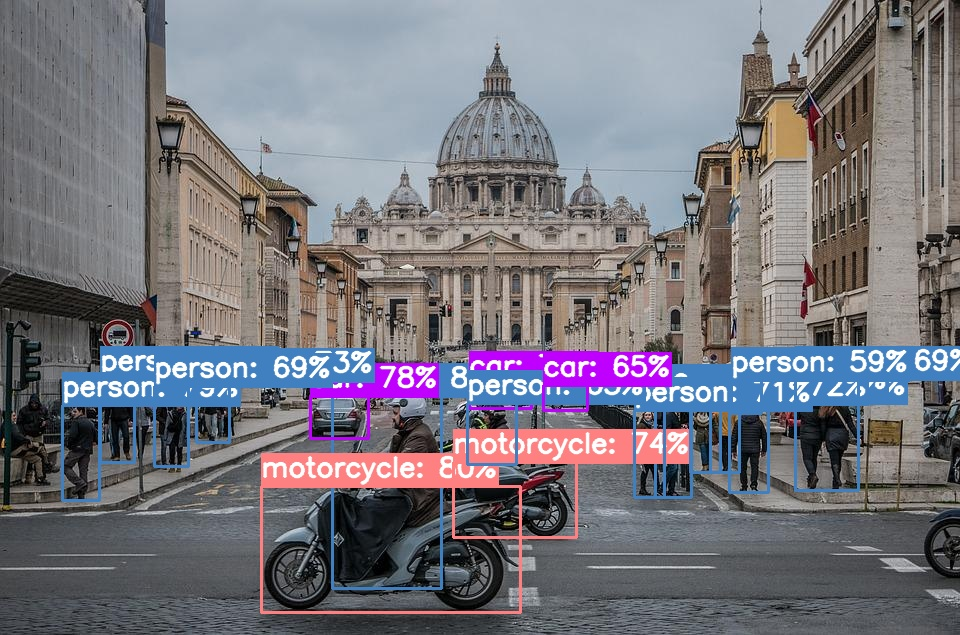

In [ ]:
from IPython.display import Image
Image('annotation-results/deepsparse-annotations/result-0.jpg')

For more details on deployment with DeepSparse, please see the [YOLOv8 integration documentation](https://github.com/neuralmagic/deepsparse/tree/main/src/deepsparse/yolov8).

# **Appendix**

## Sparse Transfer Learning Other YOLOv8 Models

Here are some sample transfer learning commands for other versions of YOLOv8.

   - YOLOv8n Pruned-Quantized:
```bash
sparseml.ultralytics.train \
  --model "zoo:cv/detection/yolov8-n/pytorch/ultralytics/coco/pruned49-none" \
  --recipe "zoo:cv/detection/yolov8-n/pytorch/ultralytics/voc/pruned49_quant-none" \
  --data "coco128.yaml" \
  --batch 8
```
   - YOLOv8m Pruned-Quantized:
```bash
sparseml.ultralytics.train \
  --model "zoo:cv/detection/yolov8-m/pytorch/ultralytics/coco/pruned80-none" \
  --recipe "zoo:cv/detection/yolov8-m/pytorch/ultralytics/voc/pruned80_quant-none" \
  --data "coco128.yaml" \
  --batch 2
```
   - YOLOv8l Pruned-Quantized:
```bash
sparseml.ultralytics.train \
  --model "zoo:cv/detection/yolov8-l/pytorch/ultralytics/coco/pruned85-none" \
  --recipe "zoo:cv/detection/yolov8-l/pytorch/ultralytics/voc/pruned85_quant-none" \
  --data "coco128.yaml" \
  --batch 1
```

SparseZoo contains mutliple variants of each version of YOLOv8 at various levels of sparsity, which can be fine-tuned onto your dataset.

[Check out the full list](https://sparsezoo.neuralmagic.com/?sort=null&useCase=detection&architectures=yolov8).

## Sparse Transfer Learning With a Custom Dataset

Because SparseML is integrated with YOLOv8, you can easily pass custom datasets to the training flows in the Ultralytics format. Check out the [Ultralytics documentation](https://docs.ultralytics.com/datasets/detect/) for more details.

### Ultralytics Dataset Format

There are three steps to creating a custom dataset for YOLOv8.

#### 1. Create `dataset.yaml`

Ultralytics uses a YAML file to pass a dataset configuration that defines:
- The dataset root directory `path` and relative paths to `train` / `val` / `test` image directories (or *.txt files with image paths)
- A class names dictionary

Here is an example for [COCO128](https://www.kaggle.com/datasets/ultralytics/coco128),
a small tutorial dataset composed of the first 128 images in COCO train2017. These same 128 images are used for both training and validation to verify our training pipeline is capable of overfitting.

```yaml
# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: ./datasets/coco128  # dataset root dir
train: images/train2017  # train images (relative to 'path') 128 images
val: images/train2017  # val images (relative to 'path') 128 images
test:  # test images (optional)

# Classes (80 COCO classes)
names:
  0: person
  1: bicycle
  2: car
  ...
  77: teddy bear
  78: hair drier
  79: toothbrush
```

#### 2. Create Labels

After using a tool like [Roboflow Annotate](https://roboflow.com/annotate?ref=ultralytics) to label your data, export your labels to the YOLO Format, with one
`*.txt` file per image (if no objects are in the image, no `*.txt` file is required).

The `*.txt` file specifications are:
- One row per object
- Each row is `class x_center y_center width height` format.
- Box coordinates must be in normalized xywh format (from 0 - 1). If your boxes are in pixels, divide `x_center` and `width` by image width, and `y_center` and `height` by image height.
- Class numbers are zero-indexed (start from 0).


#### 3. Organize Directories

Organize your train and val images and labels according to the example below. For the demo COCO128 file above,  assumes `/coco128` is inside a `/datasets` directory in your current directory. YOLOv5 locates labels automatically for each image by replacing the last instance of `/images/` in each image path with `/labels/`. For example:

```
./datasets/coco128/images/im0.jpg  # image
./datasets/coco128/labels/im0.txt  # label
```

For more details, check out the [custom dataset set tutorial](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data) in the Ultralytics repository.

### Example

The following is a real example with an aerial dataset.

#### Download the Dataset

The dataset is hosted on Google Drive ([link to file](https://drive.google.com/file/d/1GWTv9s-H387X-6wxHf2lVllqEdIv2J7N/view?usp=share_link)).

Install `gdown` and download/unzip the dataset saving in a folder called `datasets`:
```
pip install --upgrade gdown
gdown 1GWTv9s-H387X-6wxHf2lVllqEdIv2J7N
tar -xvf aerial-dataset.tar.gz
mkdir datasets
mv aerial-dataset datasets/
```

After unzipping, observe that the directory conforms to the Ultralytics format:
```
|-- aerial-dataset
  |--train
    |--images
      |--00001_frame000000_original.jpg
      ...
    |--labels
      |--00001_frame000000_original.txt
      ...
  |--val
    |--images
      |--00053_frame000000_original.jpg
      ...
    |--labels
      |--00053_frame000000_original.txt
      ...
```

Here is a sample label file for `aerial-dataset/train/labels/00001_frame000000_original.txt`:
```
0 0.719010 0.124074 0.022396 0.083333
0 0.943229 0.133333 0.039583 0.037037
0 0.787240 0.153241 0.042188 0.041667
0 0.741667 0.121759 0.017708 0.073148
0 0.693229 0.100463 0.017708 0.063889
0 0.670312 0.097222 0.025000 0.075926
0 0.648177 0.077315 0.022396 0.069444
0 0.619531 0.050463 0.022396 0.056481
0 0.492448 0.078704 0.039062 0.059259
0 0.418229 0.806019 0.034375 0.065741
0 0.349479 0.646296 0.018750 0.064815
0 0.461458 0.916204 0.037500 0.052778
```

Run the following to visualize the data:

```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random, cv2
from PIL import Image

plt.figure(figsize=(15, 15), facecolor='white')

filename_image = f"aerial-dataset/train/images/00001_frame000000_original.jpg"
filename_label = filename_image.replace('images','labels').replace('jpg','txt')
data = pd.read_csv(filename_label, header=None, delimiter=' ', names=["class", "x_center", "y_center", "width", "height"])

print(filename_image)
print(filename_label)
im = cv2.imread(filename_image)
im_size = im.shape[:2]
for _, bbox in data.iterrows():

  cls, xc, yc, w, h = bbox
  xmin = xc - w/2
  ymin = yc - h/2
  xmax = xc + w/2
  ymax = yc + h/2

  xmin *= im_size[1]
  ymin *= im_size[0]
  xmax *= im_size[1]
  ymax *= im_size[0]

  start_point = (int(xmin), int(ymin))
  end_point = (int(xmax), int(ymax))
  color = (0, 255, 0)
  thickness = 2

  im = cv2.rectangle(im, start_point, end_point, color, thickness)

plt.axis("off")
plt.imshow(im)
```

![sample-image](images/aerial-data-example.png)

#### Create a Configuration

Save the following configuration file as `aerial-dataset.yaml` in a folder called `datasets`:

```yaml
# aerial-dataset.yaml
path: ./datasets/aerial-dataset
train:
  - train/images
val:
  - val/images

# Classes
nc: 1  # number of classes
names: ['object']
```

#### Run Transfer Learning

With the configuration file setup and data downloaded, simply swap in the dataset configuration file in place of the `coco128.yaml`.

Your directory should look like the following:

```bash
|--datasets
    |--aerial-dataset.yaml
    |--aerial-dataset
        |--train
            |--images
            |--labels
        |--val
            |--images
            |--labels
```

Kick off the transfer learning:
```bash
sparseml.ultralytics.train \
  --model "zoo:cv/detection/yolov8-m/pytorch/ultralytics/coco/pruned80-none" \
  --recipe "zoo:cv/detection/yolov8-m/pytorch/ultralytics/voc/pruned80_quant-none" \
  --data datasets/aerial-dataset.yaml \
  --recipe_args '{"num_epochs":15, "qat_start_epoch": 10, "observer_freeze_epoch": 12, "bn_freeze_epoch": 12}' \
  --batch 2
```

You will notice that a `--recipe_args` argument is added, which updates the transfer
learning recipe to run for 15 epochs. While you can always create
a custom recipe file and pass a local file to script, the `--recipe_args` enables you
to modify on the fly.

Feel free to adjust the hyperparameters as needed!